In [1]:
#importing necessary libraries
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import re 
import string
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk import word_tokenize
from nltk.corpus import stopwords

# model building
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
# metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')
import re
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
import time
from sklearn.ensemble import GradientBoostingClassifier,AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

[nltk_data] Downloading package stopwords to /Users/kuan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/kuan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
#read and understand the data
df= pd.read_csv('DATASET.csv',encoding="latin-1")

def clean_text(text):
    text = re.sub(r"[^a-zA-Z]", " ", text) 
    text = text.lower().strip()                  # convert text to lowercase and strip
    text = " ".join([word for word in text.split() if not word in stopwords.words('english')])           # remove stop words    
    text = " ".join(nltk.word_tokenize(text))           # tokenize text

    return text

df['cleaned_text'] = df['text'].apply(lambda x: clean_text(x))
df.drop('Unnamed: 0',inplace=True,axis=1)


In [3]:
def get_doc(df, aspect):
    return df[df['aspectCategory'] == aspect]['cleaned_text']
def doc_str(doc):
    return ' '.join(doc)

doc_food= get_doc(df, 'food')
doc_service= get_doc(df, 'service')
doc_ambience= get_doc(df, 'ambience')
doc_price= get_doc(df, 'price')

food_str= doc_str(doc_food)
service_str= doc_str(doc_service)
ambience_str= doc_str(doc_ambience)
price_str= doc_str(doc_price)

tfidf_vectorizer_corpus = TfidfVectorizer(stop_words='english', ngram_range=(1,1))
tfidf_vectorizer_corpus.fit([food_str, service_str, ambience_str, price_str])

TfidfVectorizer(stop_words='english')

In [4]:
def get_tf_idf(doc):
    transformeddoc=tfidf_vectorizer_corpus.transform(doc)
    #get frequency distribution of word from transformeddoc
    freqs = zip(tfidf_vectorizer_corpus.get_feature_names(), np.asarray(transformeddoc.sum(axis=0)).ravel())
    #sort the frequency distribution
    sorted_freqs = sorted(freqs, key = lambda x: x[1], reverse=True)
    return sorted_freqs

FOOD=get_tf_idf(doc_food)
SERVICE=get_tf_idf(doc_service)
AMBIENCE=get_tf_idf(doc_ambience)
PRICE=get_tf_idf(doc_price)

In [5]:
#find standard deviation of food,service,ambience,and price
score=[]
def add_score(document):
    for word in document:
        score.append(word[1])
    return score
add_score(FOOD)
add_score(SERVICE)
add_score(AMBIENCE)
add_score(PRICE)
len(score)
#find standard deviation of food,service,ambience,and price
np.median(score)

0.0

In [6]:
len(FOOD)+len(SERVICE)+len(AMBIENCE)+len(PRICE)

11016

In [7]:
#shuffle 80% original to trainset and 20% to testset
train, test = train_test_split(df, test_size=0.2, random_state=42)

In [8]:
train.head()

,text,aspectCategory,polarity,cleaned_text
479,I went at 6:00 PM specifically for the pre-the...,price,positive,went pm specifically pre theater menu roasted ...
48,Try the lasagnette appetizer.,food,positive,try lasagnette appetizer
155,"Among all of the new 5th avenue restaurants, t...",price,positive,among new th avenue restaurants offers far one...
316,"Next time, we wouldn't dare ordering anything ...",food,conflict,next time dare ordering anything else simple a...
1226,"Like others have said, don't expect the restau...",service,negative,like others said expect restaurant make nite r...


In [9]:
test.head()

,text,aspectCategory,polarity,cleaned_text
1075,In summer-eat outside on a terrace (another gr...,ambience,positive,summer eat outside terrace another great featu...
1015,From the spectacular caviar to the hospitable ...,service,positive,spectacular caviar hospitable waitstaff felt l...
650,"I got the $10 10-piece dim sum combo, every bi...",food,positive,got piece dim sum combo every bite great
447,"Saturday, Nov. 6th I had a group from work com...",service,positive,saturday nov th group work come people staff a...
1290,"The staff has always been attentive and kind, ...",service,positive,staff always attentive kind always amazed hand...


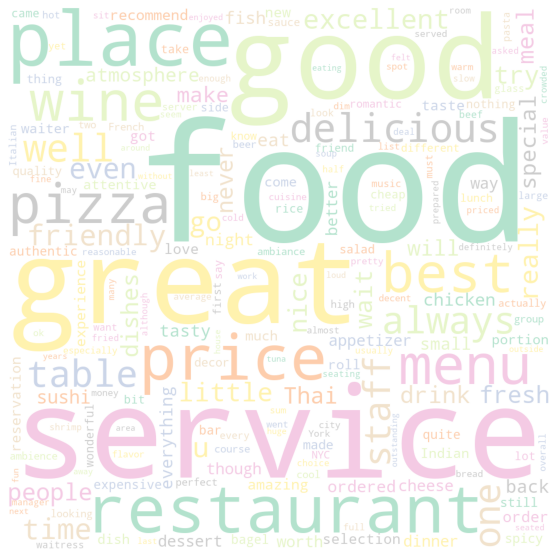

In [10]:
#cloud bag of words
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline
#plot bag of words for text
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(10, 10))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");

plot_cloud(WordCloud(width = 1000,height = 1000, random_state=1, background_color='white', colormap='Pastel2', collocations=False, stopwords = STOPWORDS).generate(" ".join(df['text'])))


In [11]:
food_dict = ['food','apple','banana','bread','butter','cake','cheese','chicken','chocolate','coffee','cookie','corn','egg','fish','flour','honey','jam','juice','milk','noodle','oil','orange','peach','pear','pepper','pie','pizza','potato','rice','salt','sauce','soup','spice','steak','sugar','tea','tomato','water','wine','yogurt']
service_dict = ['service','cashier','customer','friendly','help','manager','service','slow','staff','wait','waiter','waitress']
ambience_dict=['ambience','atmosphere']
price_dict=['price','cheap','cost','expensive','high','low','money','pay','price','rich','worth','reasonable','expensive','pricey','affordable','inexpensive','cost','prices','free','priced']

#add number of food in food_dict to df column food
def add_features(df):
    #dictionary words in text
    df['food_count'],df['service_count'],df['ambience_count'],df['price_count']=0,0,0,0
    for i in range(len(df)):
        for word in df['text'][i].split():
            if word in food_dict:
                df['food_count'][i]+=1
            elif word in service_dict:
                df['service_count'][i]+=1
            elif word in ambience_dict:
                df['ambience_count'][i]+=1
            elif word in price_dict:
                df['price_count'][i]+=1

    return df
df=add_features(df)

In [12]:
# encode aspectcategory label values
le = LabelEncoder()
train.category = le.fit_transform(train.aspectCategory)
test.category=le.transform(test.aspectCategory)

# split training set 
X_train = train.cleaned_text
y_train = train.category

# split test test set
X_test =test.cleaned_text
y_test = test.category

In [13]:
#get trainset index
train_index = train.index
#get testset index
test_index = test.index

#subset orginal data from val_index
train_data = df.loc[train_index]
test_data = df.loc[test_index]


In [14]:
#put texts into four catgeories
food_train = train_data[train_data['aspectCategory'] == 'food']['cleaned_text'].values
service_train = train_data[train_data['aspectCategory'] == 'service']['cleaned_text'].values
ambience_train = train_data[train_data['aspectCategory'] == 'ambience']['cleaned_text'].values
price_train = train_data[train_data['aspectCategory'] == 'price']['cleaned_text'].values
#convert food_train to a string
food_train = ' '.join(food_train)
service_train = ' '.join(service_train)
ambience_train = ' '.join(ambience_train)
price_train = ' '.join(price_train)
train_docs=[food_train,service_train,ambience_train,price_train]
#four documents
len(train_docs)

4

In [15]:
train_data.head(3)

,text,aspectCategory,polarity,cleaned_text,food_count,service_count,ambience_count,price_count
479,I went at 6:00 PM specifically for the pre-the...,price,positive,went pm specifically pre theater menu roasted ...,3,0,0,0
48,Try the lasagnette appetizer.,food,positive,try lasagnette appetizer,0,0,0,0
155,"Among all of the new 5th avenue restaurants, t...",price,positive,among new th avenue restaurants offers far one...,0,0,0,0


In [16]:
X_train

479     went pm specifically pre theater menu roasted ...
48                               try lasagnette appetizer
155     among new th avenue restaurants offers far one...
316     next time dare ordering anything else simple a...
1226    like others said expect restaurant make nite r...
                              ...                        
1095    food delicious halibut special husband steak s...
1130                                 excuse lousy service
1294    place good potential needs significant amount ...
860               staff attentive almost always get table
1126       okay mind oily part cause cooked way way bland
Name: cleaned_text, Length: 1124, dtype: object

In [17]:
from collections import defaultdict
#import hstack
from scipy.sparse import hstack
vect_ngram_range=[]
for i in range(0,5):
    for j in range(1,5):
        if j>=i:
            vect_ngram_range.append((i,j))
    vect_min_df=[0,1]

data_dict=defaultdict(list)

for r in vect_ngram_range:
    for min_df in vect_min_df:
        vect = TfidfVectorizer(ngram_range=r,min_df=min_df,max_features=1500).fit(train_docs)
        X_train_= vect.transform(X_train.copy())
        X_test_= vect.transform(X_test.copy())
        #merge food_count, service_count, ambience_count, price_count, text_length, exclamation with X_train and X_test
        X_train_ = hstack([X_train_, train_data[['food_count','service_count','ambience_count','price_count']]])
        X_test_ = hstack([X_test_, test_data[['food_count','service_count','ambience_count','price_count']]])
        data_dict[(r,min_df)]=(X_train_,X_test_)



In [18]:
train_data.head()
test_data.head()
data_dict[((1,1),1)][0].shape

(1124, 1504)

In [19]:
#tf_idf fit train

In [20]:
X_train.copy()

479     went pm specifically pre theater menu roasted ...
48                               try lasagnette appetizer
155     among new th avenue restaurants offers far one...
316     next time dare ordering anything else simple a...
1226    like others said expect restaurant make nite r...
                              ...                        
1095    food delicious halibut special husband steak s...
1130                                 excuse lousy service
1294    place good potential needs significant amount ...
860               staff attentive almost always get table
1126       okay mind oily part cause cooked way way bland
Name: cleaned_text, Length: 1124, dtype: object

In [21]:
#count rows that are food
food_count = train_data[train_data['aspectCategory'] == 'food'].shape[0]
#count rows that are service
service_count = train_data[train_data['aspectCategory'] == 'service'].shape[0]
#count rows that are ambience
ambience_count = train_data[train_data['aspectCategory'] == 'ambience'].shape[0]
#count rows that are price
price_count = train_data[train_data['aspectCategory'] == 'price'].shape[0]

In [22]:
# #MultinomialNB()method
# from sklearn.naive_bayes import MultinomialNB
# from sklearn import metrics
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import classification_report
# model=MultinomialNB()
# model.fit(X_train_dtm,y_train)
# y_pred_class=model.predict(vect.transform(X_test))
# print('Accuracy score: ',accuracy_score(y_test,y_pred_class))
# # print('Confusion matrix: ',confusion_matrix(y_test,y_pred_class))

# #picture of confusion matrix
# import seaborn as sns
# cm = confusion_matrix(y_test, y_pred_class)
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.show()

# print('Classification report: \n',classification_report(y_test,y_pred_class))



In [23]:
#import hp
from hyperopt import hp
models=[MultinomialNB(),LinearSVC(),LogisticRegression(),RandomForestClassifier(),XGBClassifier()]
#add randomstate=99
randomstate=99
model_configure={'MultinomialNB()':{'clf__alpha': [0.1, 0.5, 1.0, 1.5, 2.0,1,10,40],'clf__fit_prior': [True, False],'clf__class_prior': [None, [1, 1, 1, 1]]}}
#suggest hyperparameter tuning for linear svc
model_configure["LinearSVC()"]={"clf__C": [i*0.08 for i in range(0,13)], "clf__penalty": ["l1", "l2"], "clf__max_iter": (10000,),"clf__loss": ["hinge", "squared_hinge"],"clf__class_weight": [None, "balanced"],'clf__random_state':[randomstate]}
#add more paramaters for linearSVC
model_configure["LogisticRegression()"]={"clf__max_iter": (10000,),"clf__C": (0.1,0.5,1,10,40,80,200,500,800,1000),"clf__penalty": ("l2", "l1",'elasticnet'),"clf__class_weight": [None, "balanced"],"clf__solver": ["newton-cg", "sag", "saga"],'clf__random_state':[randomstate]}
model_configure["RandomForestClassifier()"]={""}
model_configure["XGBClassifier()"]={"clf__n_estimators": (10,50,),"clf__max_depth": (None,10,20),"clf__learning_rate": (0.01,0.05,), "clf__gamma": (0,0.25),"clf__reg_alpha": (0,0.25),"clf__reg_lambda": (0,0.25),'clf__random_state':[randomstate]}
#'max_depth': hp.quniform("max_depth", 3, 18, 1),
        # 'gamma': hp.uniform ('gamma', 1,9),
        # 'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        # 'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        # 'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        # 'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        # 'n_estimators': 180,
        # 'seed': 0

In [24]:
#pipeline for all models
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.model_selection import HalvingGridSearchCV

In [25]:

def model_factory(model,X_train,y_train,Xtest,ytest,classfication=True):
    pipeline = Pipeline([
    ('clf', model)
    ])
    # #hyperparamters for model
    parameters={
    }

    if(isinstance(model,XGBClassifier)):
        parameters.update(model_configure["XGBClassifier()"])
    else:
        parameters.update(model_configure[str(model)])

    # grid search under NB, score f1 using weighted average
    this_model = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=3, cv=5, scoring='f1_weighted')


    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    print(parameters)
    t0 = time.time()
    this_model.fit(X_train.copy(),y_train.copy())
    print("done in %0.3fs" % (time.time() - t0))
    print()
    print("Best score: %0.3f" % this_model.best_score_)
    print("Best parameters set for "+str(model)+" :")
    best_parameters = this_model.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
    #print test accuracy report
    print("Test Accuracy Report")
    y_pred = this_model.predict(Xtest.copy())
    if(classfication):
        print(classification_report(y_test.copy(), y_pred, target_names=le.classes_))
    else:
        print(classification_report(y_test.copy(), y_pred, target_names=le_polarity.classes_))
    return this_model
    

In [26]:
#convert str back

In [27]:
#find highest test score from performance.values


# #make classification report look better
# from sklearn.metrics import confusion_matrix
# import seaborn as sns

# cm = confusion_matrix(y_test, y_pred)
# #show labels of confusion matrix
# #clear cmap color
# sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrRd',xticklabels=le.classes_,yticklabels=le.classes_)
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.show()


# #other measures
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import f1_score
# from sklearn.metrics import precision_score
# from sklearn.metrics import recall_score
# from sklearn.metrics import cohen_kappa_score
# from sklearn.metrics import matthews_corrcoef
# print("Accuracy: "+str(accuracy_score(y_test, y_pred)))
# print("F1: "+str(f1_score(y_test, y_pred, average='weighted')))
# print("Precision: "+str(precision_score(y_test, y_pred, average='weighted')))
# print("Recall: "+str(recall_score(y_test, y_pred, average='weighted')))
# print("Cohen Kappa: "+str(cohen_kappa_score(y_test, y_pred)))
# print("Matthews Corrcoef: "+str(matthews_corrcoef(y_test, y_pred)))



        

In [28]:
model_string=[]
#convert each of the array to string
for model in models:
    model_string.append(str(model))

In [29]:
#print relevant parameters from best paramaters
def report(model,performance,polarity=False):
    #reset confusion matrix to none
    confusion_matrix=None
    import os
    import shutil
    if(polarity):
        best_parameters = this_model.best_estimator_.get_params()
        y_pred_polarity = this_model.predict(X_test_polarity.copy())
    else:
        max_score=0
        max_key=""
        for (key),(value) in performance.items():
            if(value.best_score_>max_score):
                max_score=value.best_score_
                max_key=key
        best_parameters = performance[max_key].best_estimator_.get_params()
        y_pred = performance[max_key].predict(data_dict[max_key][1])
    import pandas as pd
    # dfa = pd.DataFrame(best_parameters, index=[1])
    # #convert the name and row to columns
    # dfa = dfa.T
    # dfa.columns = ['value']
    # dfa.index.name = 'name'
    # dfa.reset_index(inplace=True)
    # #convert the value to string
    # dfa['value'] = dfa['value'].astype(str)
    # #convert the value to string
    # dfa['name'] = dfa['name'].astype(str)
    # #convert to csv and in the middle of lines
    # if(polarity):
    #     dfa.to_csv(model+"_polarity parameters.csv",index=False)
    # else:
    #     dfa.to_excel(str(model)+' parameters.xlsx', index=False, header=True)
    #export classfication_report to excel
    from sklearn.metrics import classification_report
    if(polarity):
        report = classification_report(y_test_polarity.copy(), y_pred_polarity, target_names=le_polarity.classes_,output_dict=True)
    else:
        report = classification_report(y_test.copy(), y_pred, target_names=le.classes_,output_dict=True)
    cl_report = pd.DataFrame(report).transpose()
    if(polarity):
        cl_report.to_excel(
            #model+
        "_polarity report.xlsx",index=True)
    else:
        cl_report.to_excel(
            #str(model)+
            "Accuracy_report.xlsx")
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    if(polarity):
        cm = confusion_matrix(y_test_polarity, y_pred_polarity)
        #show labels of confusion matrix
        #clear cmap color
        sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrRd',xticklabels=le_polarity.classes_,yticklabels=le_polarity.classes_)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.rcParams['figure.dpi'] = 120
        plt.rcParams['figure.figsize'] = (5,5)
    else:   
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrRd',xticklabels=le.classes_,yticklabels=le.classes_)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.rcParams['figure.dpi'] = 120
        plt.rcParams['figure.figsize'] = (5,5)
    if(polarity):
        plt.savefig(
            #model+
        "_polarity confusion_matrix.png")
    else:
        plt.savefig('confusion_matrix.png', dpi=200, bbox_inches='tight')
    #create a folder for this model
    # if(polarity):
    #     #if file exits, delete it and create a new one
    #     # if os.path.exists(model+"_polarity"):
    #     #     shutil.rmtree(model+"_polarity")
    #     os.mkdir(model+"_polarity")
    # else:
    #     #dictionary name
    #     # if os.path.exists(model+"claassification"):
    #     #     shutil.rmtree(model+"claassification")
    #     os.mkdir(model+"claassification")
    # #move all the files to this folder
    
    # if(polarity):
    #     #shutil.move(model+"_polarity parameters.csv", str(model)+"_polarity")
    #     shutil.move(model+"_polarity confusion_matrix.png", str(model)+"_polarity")
    #     shutil.move(model+"_polarity report.xlsx", str(model)+"_polarity")
    # else:
    #     #shutil.move(str(model)+' parameters.xlsx', str(model+"claassification"))
    #     shutil.move(str(model)+"Accuracy_report.xlsx", str(model+"claassification"))
    #     shutil.move('confusion_matrix.png', str(model+"claassification"))

In [30]:
food_list,service_list,ambience_list,price_list=[],[],[],[]
food_list.append(food[0] for food in FOOD[:300])
service_list.append(service[0] for service in SERVICE[:300])
ambience_list.append(ambience[0] for ambience in AMBIENCE[:300])
price_list.append(price[0] for price in PRICE[:500])


food=pd.DataFrame(food_list)
food.T.to_csv("food.csv",index=False)

service=pd.DataFrame(service_list)
service.T.to_csv("service.csv",index=False)

ambience=pd.DataFrame(ambience_list)
ambience.T.to_csv("ambience.csv",index=False)

price=pd.DataFrame(price_list)
price.T.to_csv("price.csv",index=False)


In [31]:
#open txt file and save it to an array
from codecs import latin_1_decode
import os

negative_words = []
##get current os.Path
path = os.path.dirname(os.path.abspath("Application Code.ipynb"))
#go back to one folder
#go down to the folder
path=os.path.dirname(path)
path+=("/Polarity Dictionary/negative-words.txt")

with open (path,encoding='latin1') as f:
#read the file line by line
    for line in f:
        #add the line to the array
        negative_words.append(line.strip('\n'))


In [32]:
negative_words 

['abnormal',
 'abolish',
 'abominable',
 'abominably',
 'abominate',
 'abomination',
 'abort',
 'aborted',
 'aborts',
 'abrade',
 'abrasive',
 'abrupt',
 'abruptly',
 'abscond',
 'absence',
 'absent-minded',
 'absentee',
 'absurd',
 'absurdity',
 'absurdly',
 'absurdness',
 'abuse',
 'abused',
 'abuses',
 'abusive',
 'abysmal',
 'abysmally',
 'abyss',
 'accidental',
 'accost',
 'accursed',
 'accusation',
 'accusations',
 'accuse',
 'accuses',
 'accusing',
 'accusingly',
 'acerbate',
 'acerbic',
 'acerbically',
 'ache',
 'ached',
 'aches',
 'achey',
 'aching',
 'acrid',
 'acridly',
 'acridness',
 'acrimonious',
 'acrimoniously',
 'acrimony',
 'adamant',
 'adamantly',
 'addict',
 'addicted',
 'addicting',
 'addicts',
 'admonish',
 'admonisher',
 'admonishingly',
 'admonishment',
 'admonition',
 'adulterate',
 'adulterated',
 'adulteration',
 'adulterier',
 'adversarial',
 'adversary',
 'adverse',
 'adversity',
 'afflict',
 'affliction',
 'afflictive',
 'affront',
 'afraid',
 'aggravate',

In [33]:
#open txt file and save it to an array
from codecs import latin_1_decode

path2 = os.path.dirname(os.path.abspath("Application Code.ipynb"))
#go back to one folder
#go down to the folder
path2=os.path.dirname(path2)
path2+=("/Polarity Dictionary/positive-words.txt")

positive_words = []
with open (path2,encoding='latin1') as f:
    #read the file line by line
    for line in f:
        #add the line to the array
        positive_words.append(line.strip('\n'))

In [34]:
 #add number of words of a text
def add_feature_p(data):
    data['text_length']=0
    for i in range(len(data)):
        data['text_length'][i]=len(data['text'][i].split())
    #add number of ! to df column exclamation
    data['exclamation']=0
    for i in range(len(data)):
        data['exclamation'][i]=data['text'][i].count('!')
    #divide text length by longest length of text
    data['text_length']=data['text_length']/data['text_length'].max()
    return data

df_polarity=add_feature_p(df)
df_polarity=df_polarity[['cleaned_text','polarity','text_length','exclamation']]

In [35]:
df_polarity
#add a column to the dataframe that counts the number of positive words in the text
df_polarity['positive_words']=df_polarity['cleaned_text'].apply(lambda x: len([x for x in x.split() if x in positive_words]))
#add a column to the dataframe that counts the number of negative words in the text
df_polarity['negative_words']=df_polarity['cleaned_text'].apply(lambda x: len([x for x in x.split() if x in negative_words]))

In [36]:
df_polarity


,cleaned_text,polarity,text_length,exclamation,positive_words,negative_words
0,staff horrible us,negative,0.131148,0,0,1
1,completely fair redeeming factor food average ...,positive,0.426230,0,2,1
2,food uniformly exceptional capable kitchen pro...,positive,0.442623,0,3,0
3,gabriela personaly greets recommends eat,positive,0.180328,0,0,0
4,food outstanding little perks great,positive,0.196721,0,2,0
...,...,...,...,...,...,...
1401,butter melted white wine warm cheese oozing ev...,negative,0.147541,0,1,0
1402,party private room made truly memorable helpfu...,positive,0.344262,0,2,0
1403,can not ambience place cramped guests sit aisle,negative,0.327869,0,0,1
1404,disappointed pre fixe menu choices per course ...,negative,0.409836,0,0,1


In [37]:
#filter document to positive polarity
df_polarity_positive=df_polarity[df_polarity['polarity']=='positive']
#filter document to negative polarity
df_polarity_negative=df_polarity[df_polarity['polarity']=='negative']
#filter document to neutral polarity
df_polarity_neutral=df_polarity[df_polarity['polarity']=='neutral']
#filter docuemnt to conflict  polarity
df_polarity_conflict=df_polarity[df_polarity['polarity']=='conflict']

#join them in strings
positive_string=' '.join(df_polarity_positive['cleaned_text'])
negative_string=' '.join(df_polarity_negative['cleaned_text'])
neutral_string=' '.join(df_polarity_neutral['cleaned_text'])
conflict_string=' '.join(df_polarity_conflict['cleaned_text'])

#polarity documents
polarity_documents=[positive_string,negative_string,neutral_string,conflict_string]

In [38]:
#x_train polarity based on x_train index
X_train_polarity=df_polarity.iloc[X_train.index].cleaned_text
y_train_polarity=df_polarity.iloc[X_train.index]['polarity']

#X_test polarity based on X_test index
X_test_polarity=df_polarity.iloc[X_test.index].cleaned_text
y_test_polarity=df_polarity.iloc[X_test.index]['polarity']

le_polarity = LabelEncoder()
y_train_polarity = le_polarity.fit_transform(y_train_polarity)
y_test_polarity = le_polarity.transform(y_test_polarity)


In [39]:
X_train_polarity

479     went pm specifically pre theater menu roasted ...
48                               try lasagnette appetizer
155     among new th avenue restaurants offers far one...
316     next time dare ordering anything else simple a...
1226    like others said expect restaurant make nite r...
                              ...                        
1095    food delicious halibut special husband steak s...
1130                                 excuse lousy service
1294    place good potential needs significant amount ...
860               staff attentive almost always get table
1126       okay mind oily part cause cooked way way bland
Name: cleaned_text, Length: 1124, dtype: object

In [40]:

tfidf_polarity = TfidfVectorizer(stop_words='english',ngram_range=(1,3),max_features=1000)
vect = tfidf_polarity.fit(polarity_documents)
X_train_polarity = vect.transform(X_train_polarity)
X_test_polarity =vect.transform(X_test_polarity)

# #add features to X_train_polarity sparse matrix
X_train_polarity = hstack([X_train_polarity, df_polarity.iloc[X_train.index][['text_length','exclamation','positive_words','negative_words']]])


# #add features to X_test_polarity
X_test_polarity = hstack([X_test_polarity, df_polarity.iloc[X_test.index][['text_length','exclamation','positive_words','negative_words']]])


In [41]:
#get feature df of X_train_polarity
feature_df_polarity = pd.DataFrame(X_train_polarity.toarray(), columns=tfidf_polarity.get_feature_names()+['text_length','exclamation','positive_words','negative_words'])

In [42]:
X_train_polarity

<1124x1004 sparse matrix of type '<class 'numpy.float64'>'
	with 8396 stored elements in COOrdinate format>

In [43]:
#get value of first row that is not 0
feature_df_polarity['went']

0       0.203086
1       0.000000
2       0.000000
3       0.000000
4       0.000000
          ...   
1119    0.000000
1120    0.000000
1121    0.000000
1122    0.000000
1123    0.000000
Name: went, Length: 1124, dtype: float64

In [44]:
#print relevant parameters from best paramaters
def report(model,performance,polarity=False):
    #reset confusion matrix to none
    confusion_matrix=None
    import os
    import shutil
    if(polarity):
        best_parameters = this_model.best_estimator_.get_params()
        y_pred_polarity = this_model.predict(X_test_polarity.copy())
    else:
        max_score=0
        max_key=""
        for (key),(value) in performance.items():
            if(value.best_score_>max_score):
                max_score=value.best_score_
                max_key=key
        best_parameters = performance[max_key].best_estimator_.get_params()
        y_pred = performance[max_key].predict(data_dict[max_key][1])
    import pandas as pd
    dfa = pd.DataFrame(best_parameters, index=[1])
    # #convert the name and row to columns
    dfa = dfa.T
    dfa.columns = ['value']
    dfa.index.name = 'name'
    dfa.reset_index(inplace=True)
    # #convert the value to string
    dfa['value'] = dfa['value'].astype(str)
    dfa['name'] = dfa['name'].astype(str)
    # #convert to csv and in the middle of lines
    if(polarity):
        dfa.to_csv(model+"_polarity parameters.csv",index=False)
    else:
        dfa.to_excel(str(model)+' parameters.xlsx', index=False, header=True)
    #export classfication_report to excel
    from sklearn.metrics import classification_report
    if(polarity):
        report = classification_report(y_test_polarity.copy(), y_pred_polarity, target_names=le_polarity.classes_,output_dict=True)
    else:
        report = classification_report(y_test.copy(), y_pred, target_names=le.classes_,output_dict=True)
    cl_report = pd.DataFrame(report).transpose()
    if(polarity):
        cl_report.to_excel(
            #model+
        "_polarity report.xlsx",index=True)
    else:
        cl_report.to_excel(
            #str(model)+
            "Accuracy_report.xlsx")
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    if(polarity):
        cm = confusion_matrix(y_test_polarity, y_pred_polarity)
        #show labels of confusion matrix
        #clear cmap color
        sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrRd',xticklabels=le_polarity.classes_,yticklabels=le_polarity.classes_)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.rcParams['figure.dpi'] = 120
        plt.rcParams['figure.figsize'] = (5,5)
    else:   
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrRd',xticklabels=le.classes_,yticklabels=le.classes_)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.rcParams['figure.dpi'] = 120
        plt.rcParams['figure.figsize'] = (5,5)
    if(polarity):
        plt.savefig(
            #model+
        "_polarity confusion_matrix.png")
    else:
        plt.savefig('confusion_matrix.png', dpi=200, bbox_inches='tight')
    #create a folder for this model
    if(polarity):
        #if file exits, delete it and create a new one
        if os.path.exists(model+"_polarity"):
            shutil.rmtree(model+"_polarity")
        os.mkdir(model+"_polarity")
    else:
        #dictionary name
        if os.path.exists(model+"claassification"):
            shutil.rmtree(model+"claassification")
        os.mkdir(model+"claassification")
    #move all the files to this folder
    
    if(polarity):
        shutil.move(model+"_polarity parameters.csv", str(model)+"_polarity")
        shutil.move(model+"_polarity confusion_matrix.png", str(model)+"_polarity")
        shutil.move(model+"_polarity report.xlsx", str(model)+"_polarity")
    else:
        shutil.move(str(model)+' parameters.xlsx', str(model+"claassification"))
        shutil.move(str(model)+"Accuracy_report.xlsx", str(model+"claassification"))
        shutil.move('confusion_matrix.png', str(model+"claassification"))

In [45]:
from collections import defaultdict
#k from 0 to 4 for different models,refer to models
k=1
performance1=defaultdict(object)
for (key),(Xs) in data_dict.items():
    this_model=model_factory(models[1],Xs[0],y_train,Xs[1],y_test)
    performance1[key]=this_model


performance2=defaultdict(object)
this_model=model_factory(models[0],X_train_polarity,y_train_polarity,X_test_polarity,y_test_polarity,classfication=False)

Performing grid search...
pipeline: ['clf']
parameters:
{'clf__C': [0.0, 0.08, 0.16, 0.24, 0.32, 0.4, 0.48, 0.56, 0.64, 0.72, 0.8, 0.88, 0.96], 'clf__penalty': ['l1', 'l2'], 'clf__max_iter': (10000,), 'clf__loss': ['hinge', 'squared_hinge'], 'clf__class_weight': [None, 'balanced'], 'clf__random_state': [99]}
Fitting 5 folds for each of 104 candidates, totalling 520 fits
[CV 4/5] END clf__C=0.0, clf__class_weight=None, clf__loss=hinge, clf__max_iter=10000, clf__penalty=l1, clf__random_state=99;, score=nan total time=   0.0s
[CV 1/5] END clf__C=0.0, clf__class_weight=None, clf__loss=hinge, clf__max_iter=10000, clf__penalty=l1, clf__random_state=99;, score=nan total time=   0.0s
[CV 3/5] END clf__C=0.0, clf__class_weight=None, clf__loss=hinge, clf__max_iter=10000, clf__penalty=l1, clf__random_state=99;, score=nan total time=   0.0s
[CV 5/5] END clf__C=0.0, clf__class_weight=None, clf__loss=hinge, clf__max_iter=10000, clf__penalty=l1, clf__random_state=99;, score=nan total time=   0.0s
[CV

ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True

In [ ]:
df

,text,aspectCategory,polarity,cleaned_text,food_count,service_count,ambience_count,price_count,text_length,exclamation
0,But the staff was so horrible to us.,service,negative,staff horrible us,0,1,0,0,0.131148,0
1,"To be completely fair, the only redeeming fact...",food,positive,completely fair redeeming factor food average ...,0,0,0,0,0.426230,0
2,"The food is uniformly exceptional, with a very...",food,positive,food uniformly exceptional capable kitchen pro...,1,0,0,0,0.442623,0
3,Where Gabriela personaly greets you and recomm...,service,positive,gabriela personaly greets recommends eat,0,0,0,0,0.180328,0
4,"Not only was the food outstanding, but the lit...",service,positive,food outstanding little perks great,1,0,0,0,0.196721,0
...,...,...,...,...,...,...,...,...,...,...
1401,"Butter was melted, white wine warm, cheese ooz...",food,negative,butter melted white wine warm cheese oozing ev...,2,0,0,0,0.147541,0
1402,We had a party in their private room and they ...,service,positive,party private room made truly memorable helpfu...,0,0,0,0,0.344262,0
1403,"It cannot be the ambience, because the place i...",ambience,negative,can not ambience place cramped guests sit aisle,0,0,0,0,0.327869,0
1404,We were disappointed with the pre-fixe menu of...,food,negative,disappointed pre fixe menu choices per course ...,0,0,0,0,0.409836,0


In [ ]:
max_key

((0, 1), 0)

In [ ]:
X_test

1075    summer eat outside terrace another great featu...
1015    spectacular caviar hospitable waitstaff felt l...
650              got piece dim sum combo every bite great
447     saturday nov th group work come people staff a...
1290    staff always attentive kind always amazed hand...
                              ...                        
188                          give us dinner special asked
1237                  thius must anyone loves shabu shabu
380                                        food hot tasty
354     usually order wine indian comment wine list wines
289                                             good food
Name: cleaned_text, Length: 282, dtype: object

In [ ]:
#get X_test from data_dict
X_test=data_dict[max_key][1]
X_test
y_pred=performance1[max_key].predict(X_test)

In [ ]:
X_test_polarity
y_pred_polarity=this_model.predict(X_test_polarity)

In [ ]:
test_data

,text,aspectCategory,polarity,cleaned_text,food_count,service_count,ambience_count,price_count
1075,In summer-eat outside on a terrace (another gr...,ambience,positive,summer eat outside terrace another great featu...,0,0,0,0
1015,From the spectacular caviar to the hospitable ...,service,positive,spectacular caviar hospitable waitstaff felt l...,0,0,0,0
650,"I got the $10 10-piece dim sum combo, every bi...",food,positive,got piece dim sum combo every bite great,0,0,0,0
447,"Saturday, Nov. 6th I had a group from work com...",service,positive,saturday nov th group work come people staff a...,0,1,0,0
1290,"The staff has always been attentive and kind, ...",service,positive,staff always attentive kind always amazed hand...,0,1,0,0
...,...,...,...,...,...,...,...,...
188,They didn't give us the dinner special until w...,service,negative,give us dinner special asked,0,0,0,0
1237,Thius is a must for anyone who loves Shabu-Shabu.,food,positive,thius must anyone loves shabu shabu,0,0,0,0
380,All the food was hot tasty.,food,positive,food hot tasty,1,0,0,0
354,i don't usually order wine with indian so i ca...,food,neutral,usually order wine indian comment wine list wines,2,0,0,0


In [ ]:
#x_testdata
test_data['predict_category']=le.inverse_transform(y_pred)
test_data['predict_polarity']=le_polarity.inverse_transform(y_pred_polarity)

In [ ]:
test_data

,text,aspectCategory,polarity,cleaned_text,food_count,service_count,ambience_count,price_count,predict_category,predict_polarity
1075,In summer-eat outside on a terrace (another gr...,ambience,positive,summer eat outside terrace another great featu...,0,0,0,0,ambience,positive
1015,From the spectacular caviar to the hospitable ...,service,positive,spectacular caviar hospitable waitstaff felt l...,0,0,0,0,service,positive
650,"I got the $10 10-piece dim sum combo, every bi...",food,positive,got piece dim sum combo every bite great,0,0,0,0,food,positive
447,"Saturday, Nov. 6th I had a group from work com...",service,positive,saturday nov th group work come people staff a...,0,1,0,0,service,positive
1290,"The staff has always been attentive and kind, ...",service,positive,staff always attentive kind always amazed hand...,0,1,0,0,service,positive
...,...,...,...,...,...,...,...,...,...,...
188,They didn't give us the dinner special until w...,service,negative,give us dinner special asked,0,0,0,0,service,neutral
1237,Thius is a must for anyone who loves Shabu-Shabu.,food,positive,thius must anyone loves shabu shabu,0,0,0,0,food,positive
380,All the food was hot tasty.,food,positive,food hot tasty,1,0,0,0,food,positive
354,i don't usually order wine with indian so i ca...,food,neutral,usually order wine indian comment wine list wines,2,0,0,0,food,positive


(array([0, 1, 2, 3]),
 [Text(0, 0, 'conflict'),
  Text(1, 0, 'negative'),
  Text(2, 0, 'neutral'),
  Text(3, 0, 'positive')])

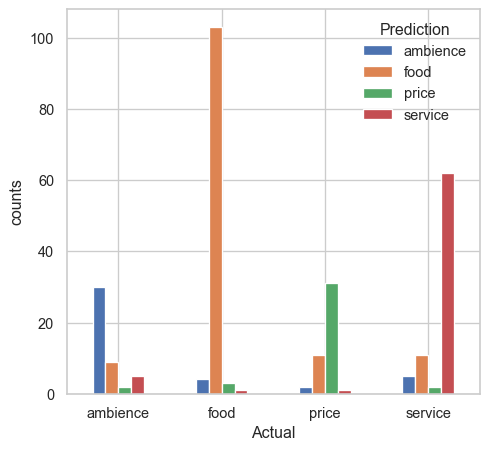

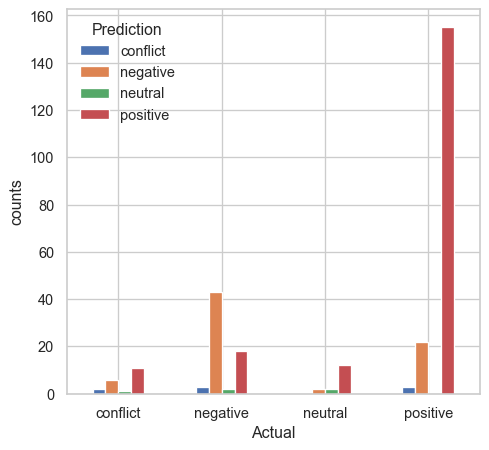

In [ ]:
sns.set_theme(style="whitegrid")
test_data[['aspectCategory','predict_category']].groupby(['aspectCategory','predict_category']).size().unstack().plot(kind='bar',stacked=False,figsize=(5,5))
#CHANGE X LABEL TO PREDICTION
plt.xlabel('Actual')
plt.ylabel('counts')
#CHANGE legend label to Actual
plt.legend(title='Prediction')

#change color palate
plt.rcParams['figure.dpi'] = 95
plt.rcParams['figure.figsize'] = (0.01,0.01)

plt.xticks(rotation=0)

#change color of bars



sns.set_theme(style="whitegrid")
test_data[['polarity','predict_polarity']].groupby(['polarity','predict_polarity']).size().unstack().plot(kind='bar',stacked=False,figsize=(5,5))
#CHANGE X LABEL TO PREDICTION
plt.xlabel('Actual')
plt.ylabel('counts')
#CHANGE legend label to Actual
plt.legend(title='Prediction')

#change color palate
plt.rcParams['figure.dpi'] = 95
plt.rcParams['figure.figsize'] = (0.01,0.01)
plt.xticks(rotation=0)





In [ ]:
test_data[['predict_category','aspectCategory']].groupby(['predict_category','aspectCategory']).size().unstack()

aspectCategory,ambience,food,price,service
predict_category,,,,
ambience,30,4,2,5
food,9,103,11,11
price,2,3,31,2
service,5,1,1,62


In [ ]:

import openpyxl
def result(category,polarity):
    return len(test_data[(test_data['predict_category']==category)&(test_data['predict_polarity']==polarity)])

aspect=['food', 'service', 'price', 'ambience']
sentiment=['positive', 'negative', 'neutral', 'conflict']

#make results pivot table

#make a dataframe ,index=aspect,columns=sentiment,value=counts
results = pd.DataFrame(columns=sentiment, index=aspect)

for aspects in aspect:
    for sentiments in sentiment:
        results.loc[aspects,sentiments]=result(aspects,sentiments)
#make a dataframe with aspect as rows and sentiment as columns
#make dataframe looks beautiful
results.style.set_properties(**{'text-align': 'center'}).set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
#make dataframe colorful
results.style.background_gradient(cmap='Blues')
#export to xlsx
results.to_excel('results.xlsx')

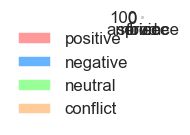

In [ ]:
#plot results
results.plot(kind='bar',stacked=False)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
#x-label horizontal 
plt.xticks(rotation=0)
#legend inside
plt.legend(loc='best')

#change plot colors to pink
#change style to white-grid
plt.style.use('seaborn-whitegrid')
#increase dpi
plt.rcParams['figure.dpi'] = 110
#change color
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#ff9999','#66b3ff','#99ff99','#ffcc99'])


#calculate the percentage of positive,negative,neutral,conflict of each aspect in results
#make a dataframe ,index=aspect,columns=sentiment,value=percentage
results_percentage = pd.DataFrame(columns=sentiment, index=aspect)
for aspects in aspect:
    for sentiments in sentiment:
        results_percentage.loc[aspects,sentiments]=results.loc[aspects,sentiments]/results.loc[aspects].sum()

In [ ]:
results_percentage

#def above as function 
def pie_plot(aspect):
    colors = ['steelblue', 'red', 'green', 'olive']
    plt.pie(results_percentage.loc[aspect], labels=sentiment, autopct='%1.1f%%', shadow=True, startangle=90, colors=colors)
    #change a modern color
    plt.style.use('seaborn-whitegrid')
    #increase dpi
    plt.rcParams['figure.dpi'] = 110
    #make labels size smaller
    plt.rcParams['font.size'] = 10
    #font inside bar chart
    plt.rcParams['font.family'] = 'sans-serif'
    #bar chart bigger
    plt.rcParams['figure.figsize'] = (6,6)
    #title food
    plt.title(aspect)
    #title different color
    plt.title(aspect.upper(), color='red')


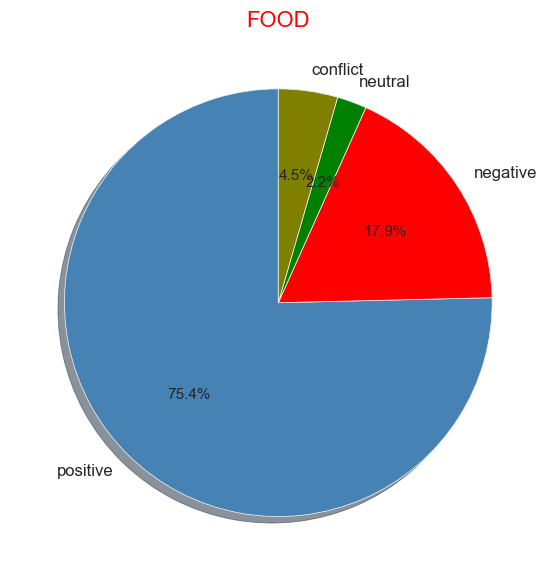

In [ ]:
pie_plot('food')

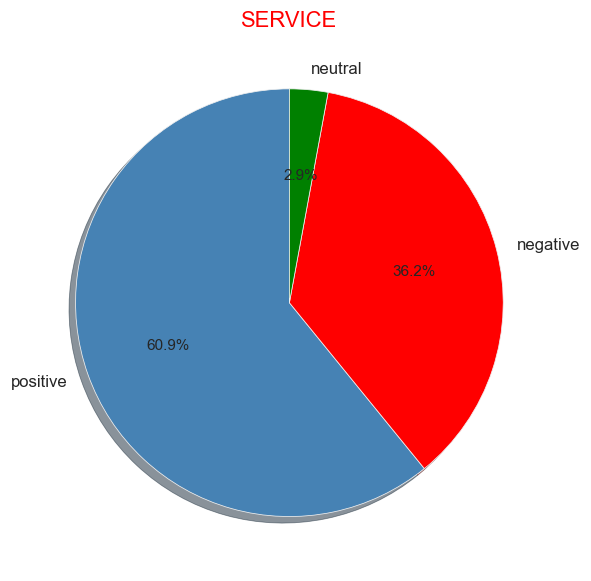

In [ ]:


def pie_plot_service(aspect):
    colors = ['steelblue', 'red', 'green', 'violet']
    plt.pie(results_percentage.loc[aspect][0:3], labels=sentiment[0:3], autopct='%1.1f%%', shadow=True, startangle=90, colors=colors)
    #change a modern color
    plt.style.use('seaborn-whitegrid')
    #increase dpi
    plt.rcParams['figure.dpi'] = 110
    #make labels size smaller
    plt.rcParams['font.size'] = 10
    #font inside bar chart
    plt.rcParams['font.family'] = 'sans-serif'
    #bar chart bigger
    plt.rcParams['figure.figsize'] = (6,6)
    #title food
    plt.title(aspect)
    #title different color
    plt.title(aspect.upper(), color='red')

pie_plot_service('service')
#remove conflict from pie_plot('service')




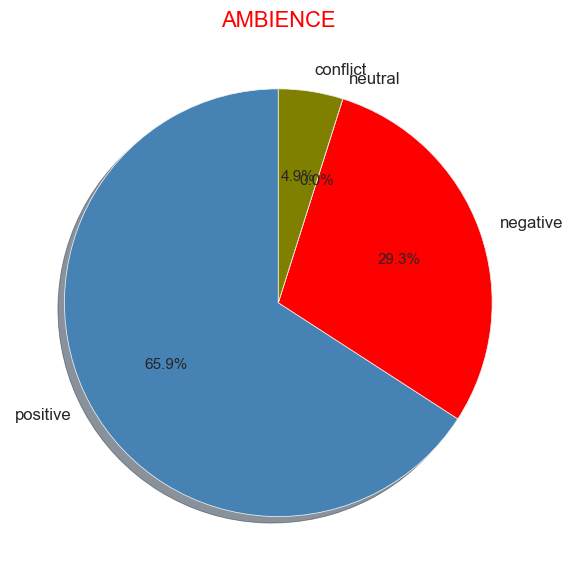

In [ ]:
pie_plot('ambience')


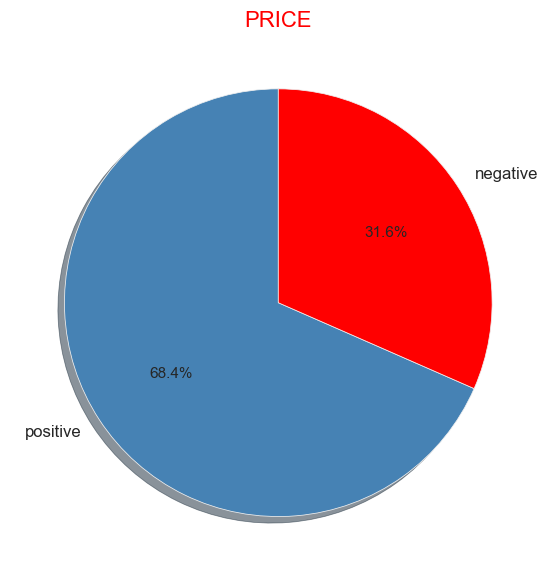

In [ ]:


def pie_plot_price(aspect):
    colors = ['steelblue', 'red', 'green', 'violet']
    plt.pie(results_percentage.loc[aspect][0:2], labels=sentiment[0:2], autopct='%1.1f%%', shadow=True, startangle=90, colors=colors)
    #change a modern color
    plt.style.use('seaborn-whitegrid')
    #increase dpi
    plt.rcParams['figure.dpi'] = 110
    #make labels size smaller
    plt.rcParams['font.size'] = 10
    #font inside bar chart
    plt.rcParams['font.family'] = 'sans-serif'
    #bar chart bigger
    plt.rcParams['figure.figsize'] = (6,6)
    #title food
    plt.title(aspect)
    #title different color
    plt.title(aspect.upper(), color='red')
pie_plot_price('price')

In [ ]:
#tf-idf transform the cleaned text in whole df
from sklearn.feature_extraction.text import TfidfVectorizer
#ngram_range=(0,1),mindf=0,maxfeature=1500
tfidf_vectorizer = TfidfVectorizer(ngram_range=(0,1),min_df=0,max_features=1500)
tfidf_vectorizer.fit(train_docs)

tfidf_matrix = tfidf_vectorizer.transform(df['cleaned_text'])
tfidf_matrix.shape
#concat food_count,service_count,ambience_count,price_count with sparse matrix
from scipy.sparse import hstack
X_1 = hstack((tfidf_matrix, df[['food_count','service_count','ambience_count','price_count']]))




In [ ]:
X_1

<1406x1504 sparse matrix of type '<class 'numpy.float64'>'
	with 9550 stored elements in COOrdinate format>

In [ ]:
#get the model from performance 1 who has highest score
max_score=0
max_key=""
for (key),(value) in performance1.items():
    if(value.best_score_>max_score):
        max_score=value.best_score_
        max_key=key
#use the best model to predict the test data
y_pred = performance1[max_key].predict(X_1)

#join y_pred to original df table with class_name
df['class_name']=le.inverse_transform(y_pred)

In [ ]:
#tf-idf transform the cleaned text in whole df
from sklearn.feature_extraction.text import TfidfVectorizer
#ngram_range=(0,1),mindf=0,maxfeature=1500
tfidf_vectorizer = TfidfVectorizer(stop_words='english',ngram_range=(1,3),max_features=1000)
tfidf_vectorizer.fit(polarity_documents)

tfidf_matrix_polarity = tfidf_vectorizer.transform(df['cleaned_text'])
#concat food_count,service_count,ambience_count,price_count with sparse matrix
from scipy.sparse import hstack
X_2 = hstack((tfidf_matrix_polarity, df_polarity[['text_length','exclamation','positive_words','negative_words']]))





In [ ]:
y_pred_p

array([1, 3, 3, ..., 1, 1, 3])

In [ ]:
#use the best model to predict the test data
y_pred_p = this_model.predict(X_2)

#join y_pred to original df table with class_name
df['pred_polarity']=le_polarity.inverse_transform(y_pred_p)

In [ ]:
df

,text,aspectCategory,polarity,cleaned_text,food_count,service_count,ambience_count,price_count,text_length,exclamation,class_name,pred_polarity
0,But the staff was so horrible to us.,service,negative,staff horrible us,0,1,0,0,0.131148,0,service,negative
1,"To be completely fair, the only redeeming fact...",food,positive,completely fair redeeming factor food average ...,0,0,0,0,0.426230,0,food,positive
2,"The food is uniformly exceptional, with a very...",food,positive,food uniformly exceptional capable kitchen pro...,1,0,0,0,0.442623,0,food,positive
3,Where Gabriela personaly greets you and recomm...,service,positive,gabriela personaly greets recommends eat,0,0,0,0,0.180328,0,service,positive
4,"Not only was the food outstanding, but the lit...",service,positive,food outstanding little perks great,1,0,0,0,0.196721,0,food,positive
...,...,...,...,...,...,...,...,...,...,...,...,...
1401,"Butter was melted, white wine warm, cheese ooz...",food,negative,butter melted white wine warm cheese oozing ev...,2,0,0,0,0.147541,0,food,positive
1402,We had a party in their private room and they ...,service,positive,party private room made truly memorable helpfu...,0,0,0,0,0.344262,0,service,positive
1403,"It cannot be the ambience, because the place i...",ambience,negative,can not ambience place cramped guests sit aisle,0,0,0,0,0.327869,0,ambience,negative
1404,We were disappointed with the pre-fixe menu of...,food,negative,disappointed pre fixe menu choices per course ...,0,0,0,0,0.409836,0,food,negative


In [ ]:
df[['aspectCategory','class_name']].groupby(['aspectCategory','class_name']).size().unstack()

class_name,ambience,food,price,service
aspectCategory,,,,
ambience,214,19,4,22
food,7,592,20,5
price,3,15,169,5
service,9,24,7,291


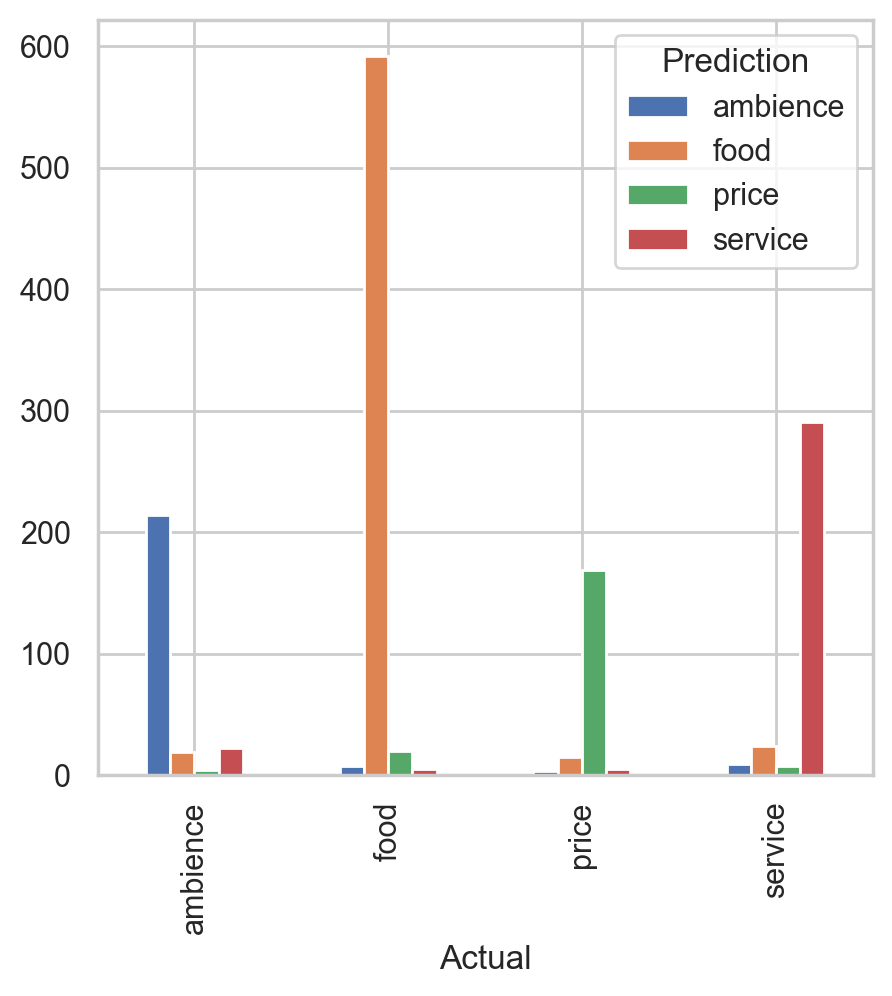

In [ ]:
sns.set_theme(style="whitegrid")
df[['aspectCategory','class_name']].groupby(['aspectCategory','class_name']).size().unstack().plot(kind='bar',stacked=False,figsize=(5,5))
#CHANGE X LABEL TO PREDICTION
plt.xlabel('Actual')
#CHANGE legend label to Actual
plt.legend(title='Prediction')

#change color palate
plt.rcParams['figure.dpi'] = 200



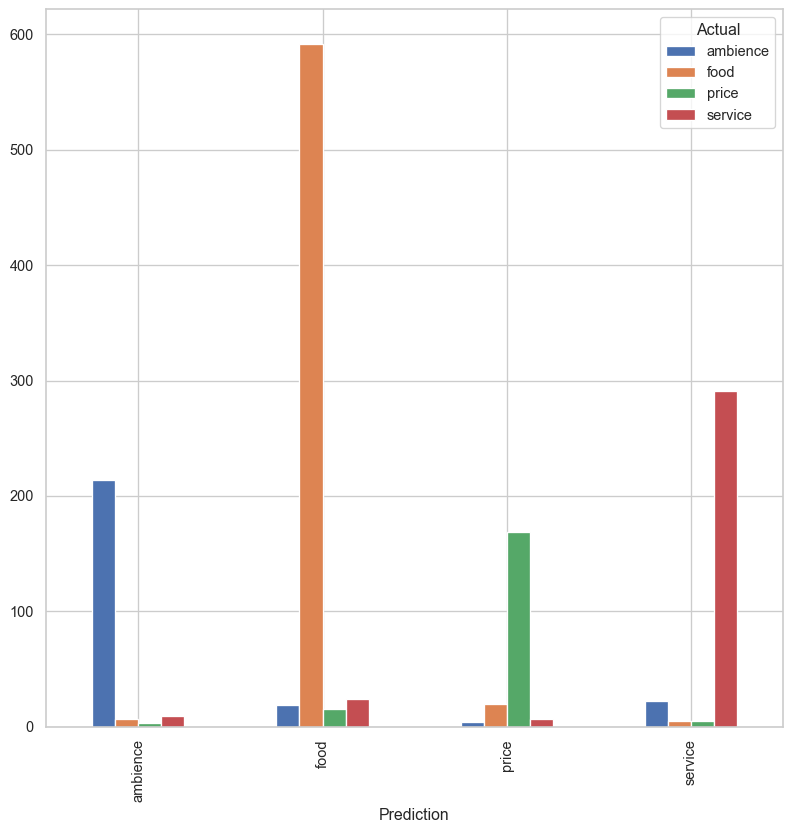

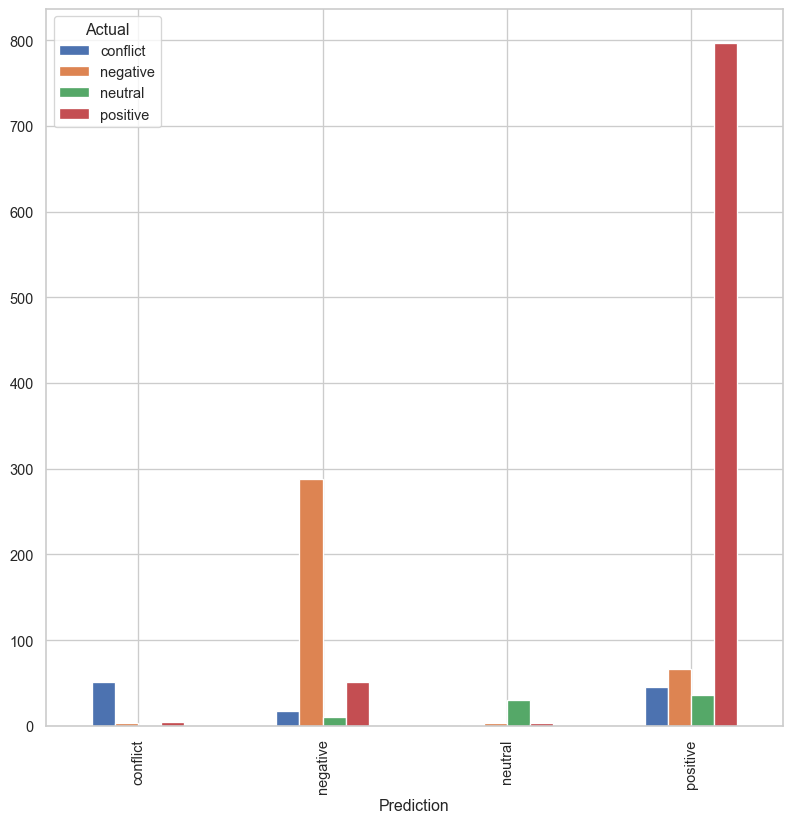

In [ ]:
#make a table to compare class name and category
sns.set_theme(style="whitegrid")
df[['class_name','aspectCategory']].groupby(['class_name','aspectCategory']).size().unstack().plot(kind='bar',stacked=False,figsize=(5,5))
#CHANGE X LABEL TO PREDICTION
plt.xlabel('Prediction')
#CHANGE legend label to Actual
plt.legend(title='Actual')

#change color palate
plt.rcParams['figure.dpi'] = 95
plt.rcParams['figure.figsize'] = (0.01,0.01)



#change theme

#make a table to compare class name and category, change plot to horizontal
#change style to fivethirtyeight
#change theme to others
sns.set_theme(style="whitegrid")



df[['pred_polarity','polarity']].groupby(['pred_polarity','polarity']).size().unstack().plot(kind='bar',stacked=False,figsize=(10,10))



#CHANGE X LABEL TO PREDICTION
plt.xlabel('Prediction')
#CHANGE legend label to Actual
plt.legend(title='Actual')
#make highest bar on bottom
plt.rcParams['figure.figsize'] = (3,3)





In [ ]:
df

,text,aspectCategory,polarity,cleaned_text,food_count,service_count,ambience_count,price_count,text_length,exclamation,class_name,pred_polarity
0,But the staff was so horrible to us.,service,negative,staff horrible us,0,1,0,0,0.131148,0,service,negative
1,"To be completely fair, the only redeeming fact...",food,positive,completely fair redeeming factor food average ...,0,0,0,0,0.426230,0,food,positive
2,"The food is uniformly exceptional, with a very...",food,positive,food uniformly exceptional capable kitchen pro...,1,0,0,0,0.442623,0,food,positive
3,Where Gabriela personaly greets you and recomm...,service,positive,gabriela personaly greets recommends eat,0,0,0,0,0.180328,0,service,positive
4,"Not only was the food outstanding, but the lit...",service,positive,food outstanding little perks great,1,0,0,0,0.196721,0,food,positive
...,...,...,...,...,...,...,...,...,...,...,...,...
1401,"Butter was melted, white wine warm, cheese ooz...",food,negative,butter melted white wine warm cheese oozing ev...,2,0,0,0,0.147541,0,food,positive
1402,We had a party in their private room and they ...,service,positive,party private room made truly memorable helpfu...,0,0,0,0,0.344262,0,service,positive
1403,"It cannot be the ambience, because the place i...",ambience,negative,can not ambience place cramped guests sit aisle,0,0,0,0,0.327869,0,ambience,negative
1404,We were disappointed with the pre-fixe menu of...,food,negative,disappointed pre fixe menu choices per course ...,0,0,0,0,0.409836,0,food,negative


In [ ]:
#how many polarity is positive when the aspect category is food
print("positive+food")
print(df[(df['aspectCategory']=='food')&(df['polarity']=='positive')].shape[0])
#how many polarity is negative when the aspect category is food
print("negative+food")
print(df[(df['aspectCategory']=='food')&(df['polarity']=='negative')].shape[0])
#how many polarity is netural when the aspect category is food
print("neutral+food")
print(df[(df['aspectCategory']=='food')&(df['polarity']=='neutral')].shape[0])
#how many polarity is conflict when the aspect category is food
print("conflict+food")
print(df[(df['aspectCategory']=='food')&(df['polarity']=='conflict')].shape[0])




positive+food
418
negative+food
117
neutral+food
44
conflict+food
45


In [ ]:

print()
#how many polarity is positive when the aspect category is service
print("positive+service")
print(df[(df['aspectCategory']=='service')&(df['polarity']=='positive')].shape[0])
#how many polarity is negative when the aspect category is service
print("negative+service")
print(df[(df['aspectCategory']=='service')&(df['polarity']=='negative')].shape[0])
#how many polarity is netural when the aspect category is service
print("neutral+service")
print(df[(df['aspectCategory']=='service')&(df['polarity']=='neutral')].shape[0])
#how many polarity is conflict when the aspect category is service
print("conflict+service")
print(df[(df['aspectCategory']=='service')&(df['polarity']=='conflict')].shape[0])



positive+service
176
negative+service
123
neutral+service
9
conflict+service
23


In [ ]:

print()
#how many polarity is positive when the aspect category is ambience
print("positive+ambience")
print(df[(df['aspectCategory']=='ambience')&(df['polarity']=='positive')].shape[0])
#how many polarity is negative when the aspect category is ambience
print("negative+ambience")
print(df[(df['aspectCategory']=='ambience')&(df['polarity']=='negative')].shape[0])
#how many polarity is netural when the aspect category is ambience
print("neutral+ambience")
print(df[(df['aspectCategory']=='ambience')&(df['polarity']=='neutral')].shape[0])
#how many polarity is conflict when the aspect category is ambience
print("conflict+ambience")
print(df[(df['aspectCategory']=='ambience')&(df['polarity']=='conflict')].shape[0])




positive+ambience
151
negative+ambience
58
neutral+ambience
16
conflict+ambience
34


In [265]:

#how many polarity is positive when the aspect category is price
print("positive+price")
print(df[(df['aspectCategory']=='price')&(df['polarity']=='positive')].shape[0])
#how many polarity is negative when the aspect category is price
print("negative+price")
print(df[(df['aspectCategory']=='price')&(df['polarity']=='negative')].shape[0])
#how many polarity is netural when the aspect category is price
print("neutral+price")
print(df[(df['aspectCategory']=='price')&(df['polarity']=='neutral')].shape[0])
#how many polarity is conflict when the aspect category is price
print("conflict+price")
print(df[(df['aspectCategory']=='price')&(df['polarity']=='conflict')].shape[0])

positive+price
111
negative+price
62
neutral+price
7
conflict+price
12
